# Deep Learning: Construct and Run a PICNN to Predict Sea Ice Concentration (SIC)

This notebook walks through the data loading and preparation for input into a physically-informed convolutional neural network (PICNN) to predict a given year's sea ice concentration (SIC) map and compare the performance to the actual SIC map. The input data includes both SIC and sea surface temperature (SST) from 1979-2024, given the annual-to-annual memory stored in SIC and the direct thermodynamic relationship between SIC and SST.

In [1]:
# Load libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.stats import pearsonr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import random

2024-12-05 17:21:43.778772: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Step 1. Load and preprocess the data

The data is loaded from the AI-ready .nc file located in the `data` folder of the cloned git repository. Make sure to change the `home_path` below to the directory you cloned the `MLGEO2024_SeaIcePrediction` repository into so that the data file can be found without error.

In [2]:
# Edit this to your home directory this repository was cloned into
home_path = "/glade/u/home/skygale/"

In [3]:
def load_data(file_path):
    """
    Function to load the data from the .nc file.
    """
    data = xr.open_dataset(file_path)
    lat = data.latitude.values
    lon = data.longitude.values
    sic_data = data["sic"][:, ::-1]
    sst_data = data["sst"][:, ::-1]
    return sic_data, sst_data, lat, lon

def preprocess_data(sic_data, sst_data):
    """
    Function to apply land mask and remove NaNs to clean data, followed by normalization.
    """
    # Mask out land (values > 1)
    sic_data = sic_data.where(sic_data <= 1)  # Keep only sea areas (sic <= 1)

    # Fill NaNs with 0
    sic_data = sic_data.fillna(0)
    sst_data = sst_data.fillna(0)

    # Normalize the sic and sst data to be between 0 and 1
    scaler = MinMaxScaler()
    sic_data_normalized = scaler.fit_transform(sic_data.values.reshape(-1, sic_data.shape[-1])).reshape(sic_data.shape)
    sst_data_normalized = scaler.fit_transform(sst_data.values.reshape(-1, sst_data.shape[-1])).reshape(sst_data.shape)

    return sic_data_normalized, sst_data_normalized


# Load and preprocess data
file_path = str(home_path) + "MLGEO2024_SeaIcePrediction/data/ready_sic_sst_data.nc"
sic_data, sst_data, lat, lon = load_data(file_path)
sic_data, sst_data = preprocess_data(sic_data, sst_data)

### Step 2. Split the data into training, testing, and validation

The data is split into ~70% training, 20% testing, and ~10% validation. The data is split using shuffle. We remove ten random years between 1979 and 2000 to remove any historical, steady sea ice state biases that would alter predictions for more drastic changes we see in recent years.

In [4]:
def remove_ten_random_years(dataset, num_years_to_remove):
    """
    Function to remove ten random years between 1979-2000.
    """
    # The first 21 years are selected (axis 0, first dimension)
    first_21_years = list(range(21))  # Indices of the first 21 years

    # Randomly select years to remove from the first 21 years
    years_to_remove = random.sample(first_21_years, num_years_to_remove)

    # Use np.delete to remove the selected years from the first axis
    return np.delete(dataset, years_to_remove, axis=0)


def split_data(sic_data, sst_data, test_size=0.2, validation_size=0.1):
    """
    Function to split data into training, validation, and test sets.
    """
    # Combine the data for input (time, lat, lon, 2)
    combined_data = np.moveaxis([sic_data, sst_data], 0, -1)

    # Offset the inputs and outputs so that we always predict the following year for test
    combined_data = np.roll(combined_data, shift=-1, axis=0)

    # Remove the last index of both arrays
    combined_data = combined_data[:-1]
    sic_data = sic_data[:-1]

    # Split the data into training and remaining (validation + test)
    X_train, X_remaining, y_train, y_remaining = train_test_split(
        combined_data,  # Combine SST and SIC for input
        sic_data,  # SIC data as target
        test_size=test_size, random_state=42, shuffle=True
    )

    # Further split remaining data into validation and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_remaining, y_remaining,
        test_size=validation_size, random_state=42, shuffle=True
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


# Removing historical biases
sic_data = remove_ten_random_years(sic_data, 10)
sst_data = remove_ten_random_years(sst_data, 10)

# Splitting data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(sic_data, sst_data)

# Print shapes to check
print("X_train shape:", X_train.shape)
print("X_val shape:  ", X_val.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:  ", y_val.shape)
print("y_test shape: ", y_test.shape)

X_train shape: (28, 160, 1440, 2)
X_val shape:   (6, 160, 1440, 2)
X_test shape:  (1, 160, 1440, 2)
y_train shape: (28, 160, 1440)
y_val shape:   (6, 160, 1440)
y_test shape:  (1, 160, 1440)


### Step 3. Build the PICNN

This PICNN will be quite simple due to the direct relationship between SIC and SST. In other words, deeper layers are not necessary to extract the needed information to make a well-informed prediction later on. We implement a thermodynamic physical constraint and a SIC saturation constraint to the CNN for physicallity. The thermodynamic constraint ensures there is no sea ice predicted where the SST is greater than freezing point temperature, and the saturation constraint stops SIC from being predicted at values below 0 or above 1.

In [5]:
def thermodynamic_constraint_loss(y_pred, sst, freezing_point=-1.8):
    """
    Function to add a penalty for SIC predictions when SST is above the freezing point.
    """
    melt_mask = tf.cast(sst > freezing_point, tf.float32)  # Mask for SST > -1.8
    violation = y_pred * melt_mask  # Penalize SIC > 0 where SST > freezing_point
    return tf.reduce_mean(tf.square(violation))  # Mean squared penalty


def combined_loss(y_true, y_pred, sst, lambda_physics=0.5):
    """
    Function to combine MSE loss with thermodynamic constraint loss.
    """
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))  # Data loss
    physics_loss = thermodynamic_constraint_loss(y_pred, sst)  # Physics loss
    return mse_loss + lambda_physics * physics_loss


def create_model(input_shape):
    """
    Function to create the neural network.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(160 * 1440, activation='sigmoid'),  # Add sigmoid activation for physical constraints
        layers.Reshape((160, 1440))  # Reshape the output to match (160, 1440)
    ])
    return model

In [6]:
# Compile the model with a custom training step
class PhysicsInformedModel(tf.keras.Model):
    def __init__(self, model, lambda_physics=0.5):
        super().__init__()
        self.model = model
        self.lambda_physics = lambda_physics

    def call(self, inputs, training=False):
        sic, sst = inputs[..., 0], inputs[..., 1]  # Extract SIC and SST
        y_pred = self.model(inputs, training=training)  # Get SIC prediction from the base model

        if training:
            # During training, calculate the loss, including the physics constraint
            loss = combined_loss(sic, y_pred, sst, self.lambda_physics)
            self.add_loss(loss)  # Add the custom loss to the model's total loss

        return y_pred

    def train_step(self, data):
        X, y = data
        _, sst = X[..., 0], X[..., 1]  # Split SIC and SST from input

        with tf.GradientTape() as tape:
            y_pred = self.model(X, training=True)
            loss = combined_loss(y, y_pred, sst, self.lambda_physics)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return {"loss": loss}

    def test_step(self, data):
        X, y = data
        _, sst = X[..., 0], X[..., 1]  # Split SIC and SST from input
        y_pred = self.model(X, training=False)
        loss = combined_loss(y, y_pred, sst, self.lambda_physics)
        return {"loss": loss}


# Create and compile the PICNN
input_shape = X_train.shape[1:]  # (lat, lon, SIC and SST)
base_model = create_model(input_shape)

# Build the base model explicitly
base_model.build(input_shape=(None, *input_shape))

# Wrap the base model with PhysicsInformedModel
physics_model = PhysicsInformedModel(base_model, lambda_physics=0.5)

# Build the physics-informed model explicitly
physics_model.build(input_shape=(None, *input_shape))

# Compile the physics-informed model
physics_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary to verify the architecture
base_model.summary()
physics_model.summary()

2024-12-05 17:21:45.912792: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-05 17:21:45.913978: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-12-05 17:21:45.996651: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b3:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.73GiB deviceMemoryBandwidth: 836.37GiB/s
2024-12-05 17:21:45.996726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-12-05 17:21:46.003122: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-12-05 17:21:46.003203: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 1438, 32)     608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 719, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 715, 64)       51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 357, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 353, 128)      204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 176, 128)      0         
_________________________________________________________________
flatten (Flatten)            (None, 360448)            0

### Step 4. Train the PICNN

The PICNN is trained and validated on the training data. The user can input values for the number of epochs and batch size used in training to increase model performance.

Epoch 1/100


2024-12-05 17:21:47.451584: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-12-05 17:21:47.472244: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2024-12-05 17:21:47.799149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-12-05 17:21:48.766737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


1/1 [==============================] - 6s 6s/step - loss: 0.3461 - val_loss: 0.3501
Epoch 2/100
1/1 [==============================] - 0s 182ms/step - loss: 0.3458 - val_loss: 0.3402
Epoch 3/100
1/1 [==============================] - 0s 134ms/step - loss: 0.3370 - val_loss: 0.2204
Epoch 4/100
1/1 [==============================] - 0s 139ms/step - loss: 0.2335 - val_loss: 0.1094
Epoch 5/100
1/1 [==============================] - 0s 145ms/step - loss: 0.1350 - val_loss: 0.1109
Epoch 6/100
1/1 [==============================] - 0s 148ms/step - loss: 0.1323 - val_loss: 0.1165
Epoch 7/100
1/1 [==============================] - 0s 135ms/step - loss: 0.1418 - val_loss: 0.1137
Epoch 8/100
1/1 [==============================] - 0s 169ms/step - loss: 0.1373 - val_loss: 0.1137
Epoch 9/100
1/1 [==============================] - 0s 140ms/step - loss: 0.1301 - val_loss: 0.1076
Epoch 10/100
1/1 [==============================] - 0s 171ms/step - loss: 0.1221 - val_loss: 0.0948
Epoch 11/100
1/1 [======

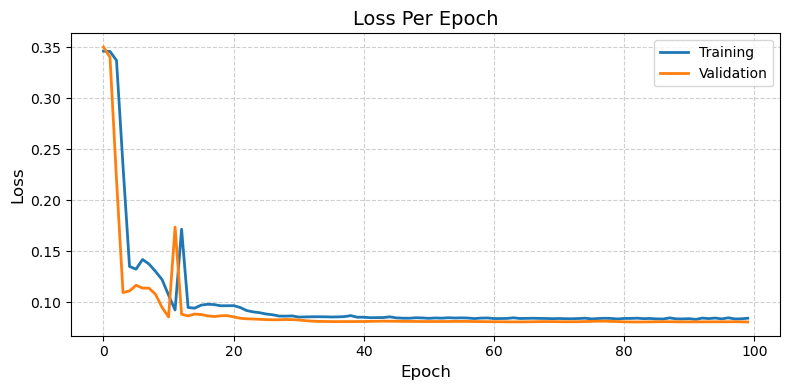

In [7]:
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    """
    Function to train the model with a given number of epochs and batch_size.
    """
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
    )
    return history


def plot_loss(history, figure_name):
    """
    Function to plot training and validation loss per epoch.
    """
    # Get loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.plot(train_loss, label='Training', linewidth=2)
    plt.plot(val_loss, label='Validation', linewidth=2)

    # Add title and labels
    plt.title('Loss Per Epoch', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')

    # Display and save the plot
    plt.tight_layout()
    plt.savefig(
        f"{str(home_path)}/MLGEO2024_SeaIcePrediction/notebooks/figures/{str(figure_name)}",
        dpi=300, bbox_inches='tight'
    )
    plt.show()


# Can edit these parameters based on model performance
epochs = 100
batch_size = 32

# Train the model
history = train_model(physics_model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

# Plot the loss per epoch
plot_loss(history, figure_name="loss_per_epoch.png")

### Step 5. Evaluate the trained model with the test data

We can calculate many metrics, but for simplicity we will look at the RMSE and Pearson Correlation Coefficient between the predicted SIC map and the actual SIC map for the chosen test year.

In [8]:
def evaluate_model(model, X_test, y_test):
    """
    Function to evaluate the physics-informed model on the test set.
    """
    # Evaluate the model on the test set (compute total loss including physics constraints)
    test_metrics = model.evaluate(X_test, y_test, return_dict=True)
    test_loss = test_metrics.get("loss", float("nan"))

    # If the loss includes physics constraints, compute RMSE using predicted and actual SIC
    y_pred = model.predict(X_test)
    mse_loss = np.mean((y_test - y_pred) ** 2)  # Manually compute MSE
    rmse = np.sqrt(mse_loss)  # Compute RMSE
    print(f"Test Loss (from model): {test_loss:.3f}")
    print(f"Computed RMSE (from predictions): {rmse:.3f}")

    # Extract the first sample (or any sample of interest) from the test set
    actual_sic = y_test[0]  # Actual SIC map for the first test sample
    pred_sic = y_pred[0]  # Predicted SIC map for the first test sample

    # Flatten and filter out NaN values for the correlation calculation
    valid_mask = ~np.isnan(actual_sic) & ~np.isnan(pred_sic)
    actual_flat = actual_sic[valid_mask].flatten()
    pred_flat = pred_sic[valid_mask].flatten()

    # Calculate the correlation coefficient (Pearson)
    if len(actual_flat) > 1:  # Ensure there are enough valid points
        corr, _ = pearsonr(actual_flat, pred_flat)
    else:
        corr = float("nan")  # Not enough data for correlation
    print(f"Computed R2 (from predictions): {corr*corr:.2f}")

    return actual_sic, pred_sic, rmse, corr


# Evaluate the physics-informed model
actual_sic, predicted_sic, rmse, corr = evaluate_model(physics_model, X_test, y_test)

1/1 [==============================] - 0s 69ms/step - loss: 0.0844
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Test Loss (from model): 0.084
Computed RMSE (from predictions): 0.197
Computed R2 (from predictions): 0.94


### Step 6. Plot the SIC maps of the test year for the actual and predicted concentrations for visual comparison

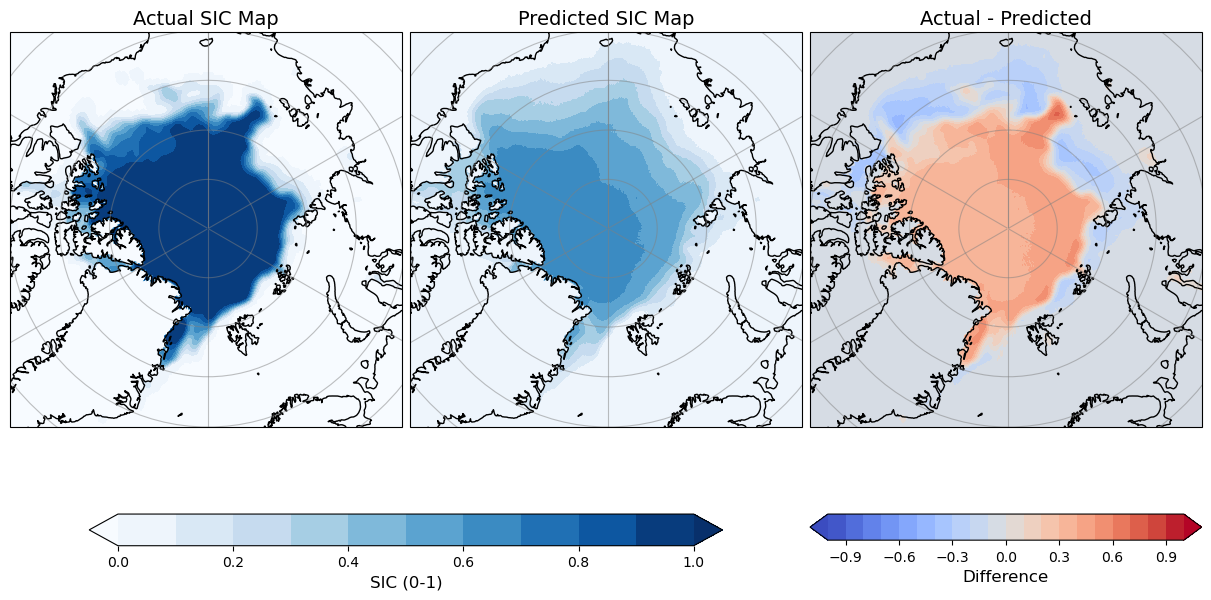

In [16]:
def predict_and_plot(actual_sic, predicted_sic, figure_name):
    """
    Function to predict test year and plot comparison.
    """
    # Replace NaN values with a placeholder (e.g., 0)
    # predicted_sic = np.nan_to_num(predicted_sic, nan=0.0)

    # Create a figure with North Polar Stereo projection
    fig, axes = plt.subplots(1, 3, figsize=(12, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()}, constrained_layout=True)

    # Set the extent to focus on the Northern Hemisphere (60N and above)
    axes[0].set_extent([0, 360, 70, 90], crs=ccrs.PlateCarree())
    axes[1].set_extent([0, 360, 70, 90], crs=ccrs.PlateCarree())
    axes[2].set_extent([0, 360, 70, 90], crs=ccrs.PlateCarree())

    # Plot actual SIC map
    actual_plot = axes[0].contourf(
        lon, lat, actual_sic[::-1],
        levels=np.linspace(0, 1, 11),
        extend='both',
        cmap='Blues', transform=ccrs.PlateCarree()
    )
    axes[0].set_title('Actual SIC Map', fontsize=14)
    axes[0].coastlines(resolution="50m")
    axes[0].add_feature(cfeature.LAND)
    axes[0].gridlines(draw_labels=False, crs=ccrs.PlateCarree(), color='gray', alpha=0.5)

    # Plot predicted SIC map
    axes[1].contourf(
        lon, lat[::-1], predicted_sic,
        levels=np.linspace(0, 1, 11),
        extend='both',
        cmap='Blues', transform=ccrs.PlateCarree()
    )
    axes[1].set_title('Predicted SIC Map', fontsize=14)
    axes[1].coastlines(resolution="50m")
    axes[1].add_feature(cfeature.LAND)
    axes[1].gridlines(draw_labels=False, crs=ccrs.PlateCarree(), color='gray', alpha=0.5)

    # Add a shared colorbar below the plots
    cbar = fig.colorbar(
        actual_plot, ax=axes[:2], orientation='horizontal', shrink=0.8, aspect=20, fraction=0.05, pad=0.1
    )
    cbar.set_label('SIC (0-1)', fontsize=12)

    # Plot difference
    difference_plot = axes[2].contourf(
        lon, lat[::-1], actual_sic-predicted_sic,
        levels=np.linspace(-1, 1, 21),
        extend='both',
        cmap='coolwarm', transform=ccrs.PlateCarree()
    )
    axes[2].set_title('Actual - Predicted', fontsize=14)
    axes[2].coastlines(resolution="50m")
    axes[2].add_feature(cfeature.LAND, color='lightgrey')
    axes[2].gridlines(draw_labels=False, crs=ccrs.PlateCarree(), color='gray', alpha=0.5)

    # Add colorbar for difference plot
    cbar = fig.colorbar(
        difference_plot, ax=axes[2], orientation='horizontal', aspect=15, fraction=0.05, pad=0.1
    )
    cbar.set_label('Difference', fontsize=12)

    # Save and show the plot
    plt.savefig(
        f"{str(home_path)}/MLGEO2024_SeaIcePrediction/notebooks/figures/{str(figure_name)}",
        dpi=300, bbox_inches='tight'
    )
    plt.show()


# Predict on test year and plot results
predict_and_plot(actual_sic, predicted_sic, figure_name="actual_vs_prediction_maps.png")